In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
from datetime import datetime

In [2]:
#формируем URL для всех файлов

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'  # Сюда вписываете вашу ссылку
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
olist_customers_datase_url = response.json()['href']


base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'  # Сюда вписываете вашу ссылку
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
olist_orders_dataset_url = response.json()['href']


base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'  # Сюда вписываете вашу ссылку
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
olist_order_items_dataset_url = response.json()['href']

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#создаем дата фреймы и сразу парсим даты
olist_customers = pd.read_csv(olist_customers_datase_url)
olist_orders = pd.read_csv(olist_orders_dataset_url, parse_dates=['order_purchase_timestamp', 'order_approved_at',
                                                                  'order_delivered_carrier_date', 
                                                                  'order_delivered_customer_date',
                                                                  'order_estimated_delivery_date'])
olist_order_items = pd.read_csv(olist_order_items_dataset_url, parse_dates=['shipping_limit_date'])

<H2>Проверяем данные на наличие пустых значений</H2>

In [4]:
#в таблице с данными о пользователях пустые значения отсутствуют
olist_customers.isnull().value_counts()

customer_id  customer_unique_id  customer_zip_code_prefix  customer_city  customer_state
False        False               False                     False          False             99441
dtype: int64

In [5]:
olist_orders.isnull().value_counts().to_frame()

0
order_id customer_id order_status order_purchase_timestamp order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date       
False    False       False        False                    False             False                        False                         False                          96461
                                                                             True                         True                          False                           1636
                                                                             False                        True                          False                           1183
                                                           True              True                         True                          False                            146
                                                                             False                        False                         False                             14
                                                           False             True                         False                         False                              1

1. Большинство заказов(96461) не имеют пустых значений, вероятней всего, они оплачены и доставлены.
2. 1636 заказов оплачены, но не переданы в службу доставки.
3. 1183 заказа оплачены, переданы в службу доставки, но не доставлены(вероятно находятся в пути)
4. 146 заказов не оплачены, не переданы в службу доставки и не доставлены.
5. 14 заказов не оплачены, но при этом имеют дату доставки. возможно оплата по таким заказам производится после получения, либо это заказы, которые например потерялись и отправка была произведена повторно. надо более подробно изучить такие заказы.
6. 1 заказ имеет даты оплаты и доставки, но при этом дата передачи в логистическую службу отсутствует.(надо попотробней посмотреть этот заказ, возможно доставка не требовалась например и покупатель забрал заказ самостоятельно)

интересно, что проверка на наличие пустых значений дает столько направлений для дальнейших изысканий.

In [6]:
#в данных с товарными позициями пустые значения отсутствуют
olist_order_items.isnull().value_counts()

order_id  order_item_id  product_id  seller_id  shipping_limit_date  price  freight_value
False     False          False       False      False                False  False            112650
dtype: int64

<H3>Смотрим более внимательно на все таблицы по очереди</H3>

<H4>1. Таблица olist_customers</H4>

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (в идеальных данных не может быть двух пользователей с одинаковым значением, является уникальным айдишником пользователя)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [7]:
olist_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
#проверяем типы данных в таблице
olist_customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [9]:
#уникальные значения в колонке customer_id
olist_customers.customer_id.nunique()

99441

In [10]:
#уникальные значения в колонке customer_unique_id
olist_customers.customer_unique_id.nunique()

96096

In [11]:
#проверяем наличие и количество дубликатов в колонке customer_unique_id
olist_customers.customer_unique_id.duplicated().value_counts()

False    96096
True      3345
Name: customer_unique_id, dtype: int64

In [12]:
#можно воспользоваться таким более наглядным способом.
olist_customers.agg(['count', 'size', 'nunique'])

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441,99441,99441
size,99441,99441,99441,99441,99441
nunique,99441,96096,14994,4119,27


In [13]:
olist_customers.shape


(99441, 5)

<H3>Итого</H3>

Количество уникальных customer_id совпадает с размером таблицы.

Количество уникальных customer_unique_id меньше размера таблицы, видимо они повторяются.

3345 довольно большое количество. 

Вероятно по какой-то причине одному и тому же customer_unique_id присваивается несколько
customer_id, возможно это особенность работы системы.

In [14]:
#сгруппируем customer_unique_id посчитаем количество customer_id на каждый customer_unique_id
#возможно понадобится в дальнейшем, 
#что бы определить почему у одного customer_unique_id присвоено больше одного customer_id

olist_customers_id_count = olist_customers.groupby('customer_unique_id', as_index=False)\
                                          .agg({'customer_id':'count'})\
                                          .sort_values(by=['customer_id'], ascending = False)\
                                          .rename(columns={"customer_id": "customer_id_count"})
olist_customers_id_count[olist_customers_id_count.customer_id_count > 1]

,customer_unique_id,customer_id_count
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...,...
35047,5cfc9643603c095fd7ed86a50fa17887,2
78003,cfb025f193db116549c9c23e4d58e3e3,2
36416,609b7feab0f0c9726929ec4891447b02,2
94630,fc19fe9ac733e36ff8227c29435c2030,2


<H4>2. Таблица olist_orders с заказами</H4>

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

In [15]:
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [16]:
#проверяем типы данных
olist_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [17]:
#для начала посмотрим, какие статусы заказа есть и в каком количестве
olist_orders_filtred = olist_orders.groupby('order_status')\
                                   .agg({'order_status':'count'})\
                                   .rename(columns={'order_status':'order_status_count'})\
                                   .reset_index()\
                                   .sort_values(by=['order_status_count'], ascending=False)
olist_orders_filtred

,order_status,order_status_count
3,delivered,96478
6,shipped,1107
1,canceled,625
7,unavailable,609
4,invoiced,314
5,processing,301
2,created,5
0,approved,2


In [18]:
#проверяем уникальные значения и общее количество строк.
#делаем вывод, что в данном дата фрейме нет повторяющихся значений order_id и customer_id
#общее количество уникальных customer_id в olist_orders равно количеству в customer_id в olist_customers
olist_orders.agg(['count', 'size', 'nunique'])

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
size,99441,99441,99441,99441,99441,99441,99441,99441
nunique,99441,99441,8,98875,90733,81018,95664,459


In [19]:
#сортируем и сравниваем cutomer_id в таблицах olist_orders и olist_customers и суммируем результат сравнения
#делаем вывод, что значения в обех таблицах полностью идентичны
(olist_orders.sort_values(by=['customer_id']).reset_index().customer_id == 
 olist_customers.sort_values(by=['customer_id']).reset_index().customer_id).sum()

99441

In [20]:
olist_orders.sort_values(by=['customer_id']).reset_index().customer_id

0        00012a2ce6f8dcda20d059ce98491703
1        000161a058600d5901f007fab4c27140
2        0001fd6190edaaf884bcaf3d49edf079
3        0002414f95344307404f0ace7a26f1d5
4        000379cdec625522490c315e70c7a9fb
                       ...               
99436    fffecc9f79fd8c764f843e9951b11341
99437    fffeda5b6d849fbd39689bb92087f431
99438    ffff42319e9b2d713724ae527742af25
99439    ffffa3172527f765de70084a7e53aae8
99440    ffffe8b65bbe3087b653a978c870db99
Name: customer_id, Length: 99441, dtype: object

In [21]:
olist_customers.sort_values(by=['customer_id']).reset_index().customer_id

0        00012a2ce6f8dcda20d059ce98491703
1        000161a058600d5901f007fab4c27140
2        0001fd6190edaaf884bcaf3d49edf079
3        0002414f95344307404f0ace7a26f1d5
4        000379cdec625522490c315e70c7a9fb
                       ...               
99436    fffecc9f79fd8c764f843e9951b11341
99437    fffeda5b6d849fbd39689bb92087f431
99438    ffff42319e9b2d713724ae527742af25
99439    ffffa3172527f765de70084a7e53aae8
99440    ffffe8b65bbe3087b653a978c870db99
Name: customer_id, Length: 99441, dtype: object

In [22]:
#проверим есть ли заказы со статусом delivered и пустой датой доставки.

df_fitred = olist_orders[(olist_orders.order_status == 'delivered') & 
                         (olist_orders['order_delivered_customer_date'].isnull())]
df_fitred

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


7 заказов имею дату передачи в службу доставки, но нет даты доставки и имеют статус доставлено. Возможно данные просто не полные, надо проверить, есть ли в таблице с товарами информация по данным заказам

1 заказ не имеет как дату передачи в службу доставки, так и дату доставки
Напрашивается два варианта, либо данные не полные, либо данный заказ забрали со склада самостоятельно.

Во всех 8 заказах есть дата подтверждения оплаты, думаю исключать такие заказы из статуса выполнено не корректно. Но надо обязательно проверить, есть ли информация от товарах по данным заказам.

In [23]:
#посмотрим на заказы, у которых дата доставки и дата передачи в логистическую службу пустые, при этом
#дата оплаты не пустая
df_not_shipped = olist_orders[((olist_orders['order_delivered_carrier_date'].isnull()) 
                              & (olist_orders['order_delivered_customer_date'].isnull())) 
                              & (olist_orders['order_approved_at'].notnull())]
df_not_shipped.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09


In [24]:
#посмотрим какие статусы у таких заказов
df_not_shipped_filted = df_not_shipped.groupby('order_status')\
                                      .agg({'order_purchase_timestamp':'count'})\
                                      .rename(columns={'order_purchase_timestamp':'order_status_count'})\
                                      .sort_values(by=['order_status_count'], ascending=False)
df_not_shipped_filted

,order_status_count
order_status,
unavailable,609
canceled,409
invoiced,314
processing,301
approved,2
delivered,1


Всего 1636 таких заказов

1. 609 заказов unavailable - недоступны
2. 409 canceled отменены, по каким-то причинам
3. 314 invoiced выставлен счет
4. 301 processing в процессе сборки заказа
5. 2 approved подтвержден
6. 1 delivered доставлен

Нет ни одного заказа, который был бы в статусе shpped
 
    created —  создан

    approved —  подтверждён

    invoiced —  выставлен счёт

    processing —  в процессе сборки заказа

    shipped —  отгружен со склада

    delivered —  доставлен пользователю 

    unavailable —  недоступен

    canceled —  отменён
    

In [25]:
#посмотрим на заказы, у которых дата доставки пустая, а дата передачи в логистическую службу не пустая, при этом
#дата оплаты не пустая. по идее, это должны быть заказы в статусе shipped
df_orders_filtred = olist_orders[((olist_orders['order_delivered_carrier_date'].notnull()) 
                              & (olist_orders['order_delivered_customer_date'].isnull())) 
                              & (olist_orders['order_approved_at'].notnull())]
df_orders_filtred.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
162,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08
231,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13
299,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03


In [26]:
#посмотрим какие статусы у таких заказов
df_orders_filtred.groupby('order_status')\
                 .agg({'order_status':'count'})\
                 .rename(columns={'order_status':'order_status_count'})\
                 .sort_values(by=['order_status_count'], ascending=False)

,order_status_count
order_status,
shipped,1107
canceled,69
delivered,7


большинство заказов, как и ожидалось, имеют статус shipped - 1107.
69 заказов canceled(отменены)
ну и 7 заказов доставлены, мы их находили ранее.


In [27]:
#посмотрим заказы, у которых дата оплаты пустая, в каих статусах они находятся
df_orders_filtred = olist_orders[olist_orders['order_approved_at'].isnull()]
df_orders_filtred

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaT,NaT,NaT,2017-07-25
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaT,NaT,NaT,2017-10-16
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01


таких заказов у нас 160

141 отменен - это понятно

14 доставлено, опять же возможна оплата после доставки, либо была повторная отправка потерявшихся(или не качественных товаров) и происходит отгрузка без оплаты.

5 создано - то же понятно.

In [28]:
df_orders_filtred.groupby('order_status')\
                 .agg({'order_status':'count'})\
                 .rename(columns={'order_status':'order_status_count'})\
                 .sort_values(by=['order_status_count'], ascending=False)

,order_status_count
order_status,
canceled,141
delivered,14
created,5


<H4>2. Таблица olist_order_items</H4>

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа (не содержит информацию о количестве товаров)

product_id —  уникальный идентефикатор товара (аналог штрихкода)

seller_id — уникальный идентефикатор производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [29]:
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [30]:
#смотрим размер таблицы
olist_order_items.shape

(112650, 7)

In [31]:
#проверяем типы данных
olist_order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [32]:
#проверяем количество уникальных значений и общий размер датафрейма
olist_order_items.agg(['count', 'size', 'nunique'])

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650,112650,112650,112650,112650,112650
size,112650,112650,112650,112650,112650,112650,112650
nunique,98666,21,32951,3095,93318,5968,6999


In [33]:
#ищем order_id, которые встречаются более одного раза
olist_order_items.groupby('order_id').agg({'order_id':'count'})\
                                     .rename(columns={'order_id':'order_id_count'})\
                                     .sort_values(by=['order_id_count'], ascending = False).head(5)

,order_id_count
order_id,
8272b63d03f5f79c56e9e4120aec44ef,21
1b15974a0141d54e36626dca3fdc731a,20
ab14fdcfbe524636d65ee38360e22ce8,20
9ef13efd6949e4573a18964dd1bbe7f5,15
428a2f660dc84138d969ccd69a0ab6d5,15


In [34]:
#проверяем один из такиз заказов. очевидно что order_item_id это порядковый номер внутри одного заказа.
#а product_id может встречатья внутри однго заказа несколько раз. можно посчитать количество.
olist_order_items[olist_order_items.order_id == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [35]:
#группируем по order_id и product_id, считаем количество каждой позиции и просуммируем цену.
olist_order_items_filtred = olist_order_items[olist_order_items.order_id == '8272b63d03f5f79c56e9e4120aec44ef']\
                            .groupby(['order_id','product_id'])\
                            .agg({'product_id':'count','price':'sum'})#\     
olist_order_items_filtred.columns = ['quantity', 'price_total']
                    

In [36]:
olist_order_items_filtred

quantity  \
order_id                         product_id                                   
8272b63d03f5f79c56e9e4120aec44ef 05b515fdc76e888aada3c6d66c201dff        10   
                                 270516a3f41dc035aa87d220228f844c        10   
                                 79ce45dbc2ea29b22b5a261bbb7b7ee7         1   

                                                                   price_total  
order_id                         product_id                                     
8272b63d03f5f79c56e9e4120aec44ef 05b515fdc76e888aada3c6d66c201dff         12.0  
                                 270516a3f41dc035aa87d220228f844c         12.0  
                                 79ce45dbc2ea29b22b5a261bbb7b7ee7          7.8

In [37]:
#сделаем такую же группировку для всех order_id
olist_order_items_filtred_all = olist_order_items\
                            .groupby(['order_id','product_id'])\
                            .agg({'product_id':'count','price':'sum'})

olist_order_items_filtred_all.columns = ['quantity', 'price_total']

olist_order_items_filtred_all = olist_order_items_filtred_all.reset_index() #сбросим иднексы

In [38]:
olist_order_items_filtred_all

,order_id,product_id,quantity,price_total
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.90
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,239.90
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,199.00
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,199.90
...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,1,299.99
102421,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,1,350.00
102422,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,1,99.90
102423,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,1,55.99


In [39]:
#сделаем заготовку, что бы увидеть общую сумму по каждому order_id
olist_order_items_filtred_all = olist_order_items_filtred_all.groupby('order_id',as_index = False)\
                                                             .agg({'price_total':'sum'})\
                                                             .sort_values(by=['price_total'], ascending=False)
olist_order_items_filtred_all

,order_id,price_total
1455,03caa2c082116e1d31e67e9ae3700499,13440.00
44467,736e1922ae60d0d6a89247b851902527,7160.00
3130,0812eb902a67711a1cb742b3cdaa65ae,6735.00
98298,fefacc66af859508bf1a7934eab1e97f,6729.00
94439,f5136e38d1a14a4dbd87dff67da82701,6499.00
...,...,...
21805,38bcb524e1c38c2c1b60600a80fc8999,2.90
89758,e8bbc1d69fee39eee4c72cb5c969e39d,2.29
93208,f1d5c2e6867fa93ceee9ef9b34a53cbf,2.20
24174,3ee6513ae7ea23bdfab5b9ab60bffcb5,0.85


In [40]:
olist_order_items [olist_order_items.order_id == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


<H2>Что же будем считать покупкой?</H2>

Судя по тому, что я прочитал в интернете по этому поводу, как правило фактом перехода собственности на товар является факт отгрузки товара.

Есть практика, когда собственность переходит по факту оплаты, но она используется довольно редко.

Соответственно сделки, по которым товары были отгружены, но не оплачены, будем считать завершенными.

Остается 8 заказов, у которых статус заказа delivered, но не заполнен столбец с датой отгрузки. Их то же будем считать завершенными. Например не пришло автоматическое подтверждение от службы доставки, но есть было подтверждение от клиента и статус вручную поменяли. По крайней мере исходя из данных нет оснований полагать, что эти товары не были доставлены.

Доля заказов с неполными данными минимальна. Не думаю, что они сильно повлияют на расчет основных метрик. Хотя, это вопрос то же можно изучить, посчитать разные варианты и оценить различия.

<b>Покупкой будем считать все заказы, у которых статус Delivered</b>



<H1>Задания:</H1>

Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (15 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Описание подхода можно найти тут. (23 балла)

### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 


In [41]:
#делаем merge таблицы с заказами и таблицы с уникальными пользователями
olist_orders_merge_uniq = olist_orders.merge(olist_customers, on='customer_id', how='left')

In [42]:
olist_orders_merge_uniq[olist_orders_merge_uniq.order_status == 'delivered'].agg(['count', 'size', 'nunique'])

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,96478,96478,96478,96478,96464,96476,96470,96478,96478,96478,96478,96478
size,96478,96478,96478,96478,96478,96478,96478,96478,96478,96478,96478,96478
nunique,96478,96478,1,95956,88274,80106,95658,445,93358,14889,4085,27


In [43]:
#считаем количество уникальных пользователе, которые сделали только один заказ и при этом статус delivered
olist_orders_merge_uniq[olist_orders_merge_uniq.order_status == 'delivered'].groupby('customer_unique_id',as_index=False)\
    .agg({'order_id':'count'}) \
    .query('order_id == 1')\
    .order_id.sum()

90557

 Т.к. все пользователи в выборке сделали только один заказ, то просто просуммируем их. Ответ на 1 задание <b>90557</b>

In [44]:
#ради интереса посмотрим на тех пользователей, кто сделал более 1 заказа
olist_orders_merge_uniq[olist_orders_merge_uniq.order_status == 'delivered'].groupby('customer_unique_id',as_index=False)\
    .agg({'order_id':'count'}) \
    .query('order_id > 1')\
    .order_id.sum()

5921

In [45]:
#отсортируем и посмотрим топ 10 пользователей по количеству заказов
olist_orders_merge_uniq[olist_orders_merge_uniq.order_status == 'delivered'].groupby('customer_unique_id',as_index=False)\
    .agg({'order_id':'count'}) \
    .query('order_id > 1')\
    .sort_values(by='order_id', ascending=False)\
    .head(10)

,customer_unique_id,order_id
51431,8d50f5eadf50201ccdcedfb9e2ac8455,15
22779,3e43e6105506432c953e165fb2acf44c,9
36706,6469f99c1f9dfae7733b25662e7f1782,7
10060,1b6c7548a2a1f9037c1fd3ddfed95f33,7
73921,ca77025e7201e3b30c44b472ff346268,7
6964,12f5d6e1cbf93dafd9dcc19095df0b3d,6
80538,dc813062e0fc23409cd255f7f53c7074,6
87885,f0e310a6839dce9de1638e0fe5ab282a,6
36500,63cfc61cee11cbe306bff5857d00bfe4,6
26257,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


In [46]:
df_uniq_count = olist_orders_merge_uniq[olist_orders_merge_uniq.order_status == 'delivered']\
    .groupby('customer_unique_id',as_index=False)\
    .agg({'order_id':'count'}) \
    .query('order_id > 1')\
    .sort_values(by='order_id', ascending=False)  

In [47]:
#228 пользователей, которые сделали более 2 заказов
olist_orders_merge_uniq[olist_orders_merge_uniq.order_status == 'delivered']\
    .groupby('customer_unique_id',as_index=False)\
    .agg({'order_id':'count'}) \
    .query('order_id > 2')\
    .sort_values(by='order_id', ascending=False).shape

(228, 2)

In [48]:
df_uniq_count.order_id.describe()

count    2801.000000
mean        2.113888
std         0.503796
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        15.000000
Name: order_id, dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


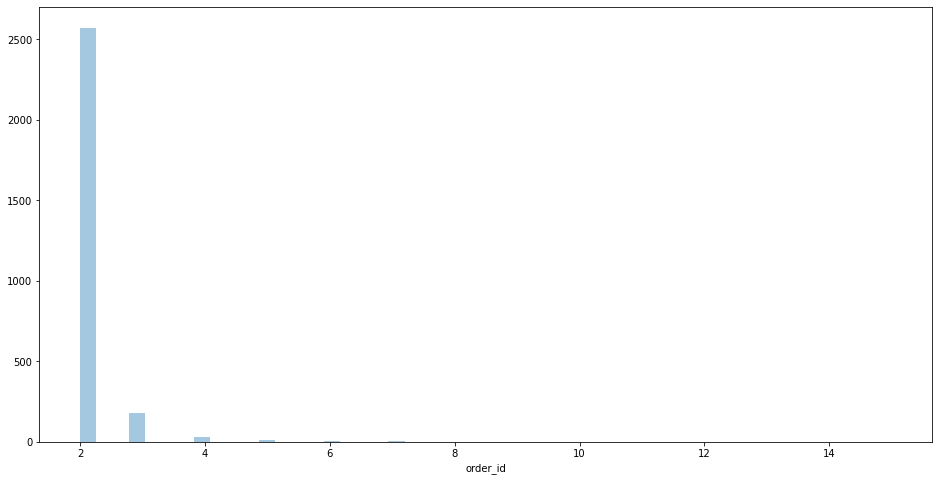

In [49]:
plt.subplots(1,1,figsize=(16,8))
sns.distplot(df_uniq_count.order_id, kde = False)

Вывод. Большее количество пользователей сделали только один заказ. Из тех кто сделал 2 или более заказа, большинство сделали два заказа. Пользователей, которые сделали более 2 заказов очень мало.

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)


In [193]:
#считаем среднее количество заказов с группировкой по месяцам искулючим заказы, которые в процессе доставки 
avg_orders = olist_orders.query('order_status != "delivered"')\
    .groupby([pd.Grouper(freq='M', key='order_purchase_timestamp'),'order_status'],as_index=False) \
    .agg({'order_id':'count'}) \
    .groupby('order_status',as_index=False)\
    .agg({'order_id':'mean'}) \
    .rename(columns={'order_id':'avg_value'})

#добавим сортировку для наглядности
avg_orders = avg_orders[avg_orders.order_status != 'shipped'].sort_values(by='avg_value')
avg_orders

,order_status,avg_value
0,approved,1.000000
2,created,1.666667
3,invoiced,14.952381
4,processing,15.842105
1,canceled,26.041667
6,unavailable,29.000000


    created —  создан

    approved —  подтверждён

    invoiced —  выставлен счёт

    processing —  в процессе сборки заказа

    shipped —  отгружен со склада

    delivered —  доставлен пользователю 

    unavailable —  недоступен

    canceled —  отменён

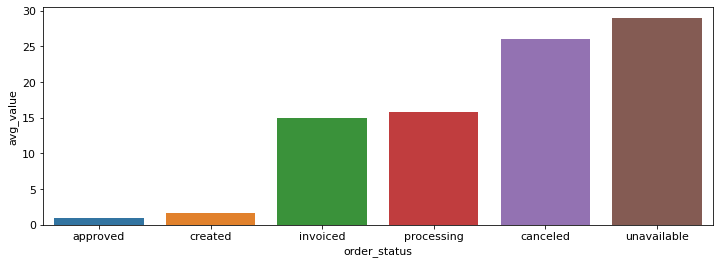

In [194]:
plt.figure(figsize=(12,4))
sns.barplot(x = avg_orders.order_status, y = avg_orders.avg_value)

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 


In [52]:
#мерджим и создаем дата фрейм для дальнейших манипуляций
olist_orders_and_order_items = olist_orders.merge(olist_order_items, how='left',on='order_id')

In [53]:
#проверяем, что все склеилось правильно, ранее у этого заказа была 21 позиция.
olist_orders_and_order_items[olist_orders_and_order_items.order_id == '8272b63d03f5f79c56e9e4120aec44ef'].shape

(21, 14)

In [54]:
# добавляем новую колонку с днем недели.
olist_orders_and_order_items['day_time'] = olist_orders.order_purchase_timestamp.dt.day_name()

In [55]:
#проверяем на пустые значения.
olist_orders_and_order_items[olist_orders_and_order_items.order_status == 'delivered'].day_time.isna().sum()

13607

In [56]:
#удаляем пустые значения.
olist_orders_and_order_items = olist_orders_and_order_items.dropna()

In [57]:
#группируем, считаем количество заказов в каждый день недели, сортируем и оставляем только максимальный
id_purchase_day = olist_orders_and_order_items.query('order_status == "delivered"') \
    .groupby(['product_id','day_time'],as_index=False) \
    .agg({'order_status':'count'}) \
    .sort_values(by='order_status', ascending = False)\
    .drop_duplicates(subset=["product_id"], keep='first') \

У данного метода есть минус, у каких-то товаров в какие-то дни недели, может совпадать количество и данный метод оставит только один день недели.

In [58]:
id_purchase_day.head()

,product_id,day_time,order_status
14953,422879e10f46682990de24d770e7f83d,Monday,83
38720,aca2eb7d00ea1a7b8ebd4e68314663af,Monday,74
34409,99a4788cb24856965c36a24e339b6058,Monday,72
18864,53759a2ecddad2bb87a079a1f1519f73,Monday,67
12758,389d119b48cf3043d311335e499d9c6b,Thursday,62


Хотелось бы сделать функцию, которая бы перебирала все значения и вычисляла максимальное, а если их несколько, то делала список дней недели. Но увы не располагаю таким количеством свободного времени на данный момент.

In [59]:
#интерестно посмотреть в какой из дней недели больше всего было заказов. Произведем группировку и суммирование.
weekday_orders = olist_orders_and_order_items.query('order_status == "delivered"') \
    .groupby(['product_id','day_time'],as_index=False) \
    .agg({'order_status':'count'}) \
    .sort_values(by='order_status', ascending = False)\
    .groupby('day_time', as_index=False)\
    .agg({'order_status':'sum'})\
    .sort_values(by='order_status', ascending=False)
#большее количество заказов делают в понедельник, количество плавно снижается к концу недели.
weekday_orders

,day_time,order_status
1,Monday,15727
5,Tuesday,15497
6,Wednesday,15073
4,Thursday,14352
0,Friday,13725
3,Sunday,11610
2,Saturday,10585


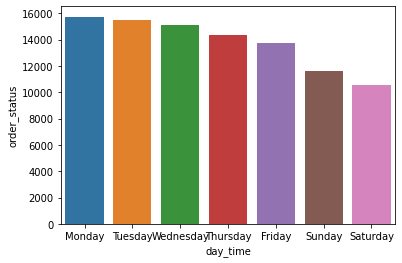

In [60]:
#построим график для большей наглядности.
sns.barplot(x=weekday_orders.day_time, y=weekday_orders.order_status)

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

In [61]:
#переведем дату в формат месяца
olist_orders_merge_uniq.order_purchase_timestamp = olist_orders_merge_uniq.order_purchase_timestamp.dt.month_name()

In [62]:
#определяем количество недель в каждом месяце
olist_orders_merge_uniq['weeks'] = olist_orders.order_purchase_timestamp.dt.days_in_month / 7

In [63]:
olist_orders_merge_uniq

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,weeks
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,October,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,July,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,August,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,November,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,February,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,March,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,4.428571
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,February,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,4.000000
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,August,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,4.428571
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,January,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,4.428571


In [64]:
customer_by_month = olist_orders_merge_uniq.query('order_status == "delivered"') \
    .groupby(['customer_unique_id','order_purchase_timestamp','weeks'], as_index=False) \
    .agg({'order_status':'count'}) \
    .groupby(['customer_unique_id','order_purchase_timestamp','weeks'],as_index=False) \
    .agg({'order_status':'sum'}) \
    .rename(columns={'order_purchase_timestamp':'month','order_status':'avg_orders'}) 

In [65]:
customer_by_month.head()

,customer_unique_id,month,weeks,avg_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1
2,0000f46a3911fa3c0805444483337064,March,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,1


In [66]:
#делим количество покупок в месяце на количество недель.
customer_by_month.avg_orders = customer_by_month.avg_orders / customer_by_month.weeks

In [67]:
#отсортируем и посмотрим топ 10
customer_by_month.sort_values(by='avg_orders', ascending=False).head(10)

,customer_unique_id,month,weeks,avg_orders
7097,12f5d6e1cbf93dafd9dcc19095df0b3d,January,4.428571,1.354839
67329,b4e4f24de1e8725b74e4a1f4975116ed,February,4.000000,1.000000
23212,3e43e6105506432c953e165fb2acf44c,February,4.000000,1.000000
60341,a239b8e2fbce33780f1f1912e2ee5275,February,4.000000,1.000000
65740,b08fab27d47a1eb6deda07bfd965ad43,September,4.285714,0.933333
14053,25a560b9a6006157838aab1bdbd68624,April,4.285714,0.933333
52401,8d50f5eadf50201ccdcedfb9e2ac8455,August,4.428571,0.903226
49103,83e7958a94bd7f74a9414d8782f87628,January,4.428571,0.903226
52402,8d50f5eadf50201ccdcedfb9e2ac8455,July,4.428571,0.903226
74523,c8460e4251689ba205045f3ea17884a1,August,4.428571,0.903226


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


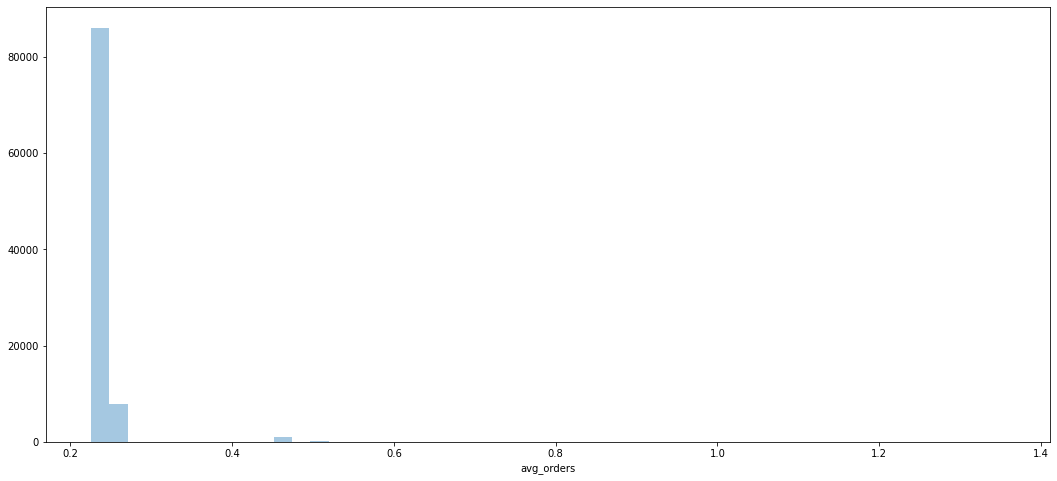

In [68]:
#построим график, что бы посмотреть, где в основное количество значений.
plt.figure(figsize=(18,8))
sns.distplot(customer_by_month.avg_orders, kde=False)

Большинство значений не превышает 0.3

### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

In [136]:
#мерджим датафрейм olist_customers к olist_orders и сразу отбираем заказы со статусом delivered
orders_uniq_id = olist_orders.merge(olist_customers, how='left', on='customer_id')[olist_orders.order_status == 'delivered']
orders_uniq_id.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


In [137]:
#переводим колонку order_purchase_timestamp в формат период Y-M
orders_uniq_id.order_purchase_timestamp = orders_uniq_id.order_purchase_timestamp.dt.to_period('M')
orders_uniq_id.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP


In [138]:
#оставляем только нужные для дальнейшей работы колонки и сортируем по дате
orders_uniq_id = orders_uniq_id[['customer_unique_id','order_id','order_purchase_timestamp']]
orders_uniq_id = orders_uniq_id.sort_values('order_purchase_timestamp')\
.rename(columns={'order_purchase_timestamp':'order_date'})
orders_uniq_id.head()

,customer_unique_id,order_id,order_date
30710,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,2016-09
40692,2e15add79c76241beffe812a24ad3a31,cb29497c3782a76b57327c055d58b0e0,2016-10
24708,d6a930873ee3f80aa823cb1d4baca58d,0ca768c507d1fc3c61bd950bb1c5231a,2016-10
94421,f7ace36f8a10c4b2ede9ea7708e01454,2e8e21db96a8ab922e51cd297678c6b2,2016-10
53268,4a6959f9a4aca95bb3733032d0a50c9e,25f680bf746bec3df11d48318ff015de,2016-10


In [139]:
#создаем дата фрейм с датото первого заказа по каждому customer_unique_id
first_date_order = orders_uniq_id.groupby('customer_unique_id',as_index=False) \
    .agg({'order_date':'first'})\
    .rename(columns={'order_date':'first_order'})
first_date_order.head()

,customer_unique_id,first_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [140]:
#добавляем новую колонку first_order
orders_uniq_id = orders_uniq_id.merge(first_date_order, how='inner',on='customer_unique_id')
orders_uniq_id.head()

,customer_unique_id,order_id,order_date,first_order
0,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,2016-09,2016-09
1,2e15add79c76241beffe812a24ad3a31,cb29497c3782a76b57327c055d58b0e0,2016-10,2016-10
2,d6a930873ee3f80aa823cb1d4baca58d,0ca768c507d1fc3c61bd950bb1c5231a,2016-10,2016-10
3,f7ace36f8a10c4b2ede9ea7708e01454,2e8e21db96a8ab922e51cd297678c6b2,2016-10,2016-10
4,4a6959f9a4aca95bb3733032d0a50c9e,25f680bf746bec3df11d48318ff015de,2016-10,2016-10


In [141]:
orders_uniq_id_filtred = orders_uniq_id.groupby(['first_order','order_date'])\
    .agg({'customer_unique_id':'nunique'})

In [142]:
orders_uniq_id_filtred.head()

customer_unique_id
first_order order_date                    
2016-09     2016-09                      1
2016-10     2016-10                    262
            2017-04                      1
            2017-07                      1
            2017-09                      1

In [143]:
def cohort(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

orders_uniq_id_filtred = orders_uniq_id_filtred.groupby(level=0).apply(cohort)
orders_uniq_id_filtred.head()

customer_unique_id  cohort_period
first_order order_date                                   
2016-09     2016-09                      1              1
2016-10     2016-10                    262              1
            2017-04                      1              2
            2017-07                      1              3
            2017-09                      1              4

In [144]:
orders_uniq_id_filtred = orders_uniq_id_filtred \
.pivot_table(columns='cohort_period', index = 'first_order',values='customer_unique_id')

In [145]:
orders_uniq_id_filtred

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_order,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0
2017-04,2256.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN
2017-05,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,9.0,12.0,8.0,1.0,6.0,7.0,NaN,NaN
2017-06,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,7.0,4.0,6.0,9.0,11.0,5.0,5.0,7.0,NaN,NaN,NaN


In [146]:
#создаем массив с данными количестве первонача
val_orders = orders_uniq_id_filtred[1]

In [147]:
#делим построчно все элементы на значения массива val_orders и переведем в проценты.
retention = round(orders_uniq_id_filtred.divide(val_orders, axis=0) ,4)

In [ ]:
retention

In [149]:
retention[retention[3] == retention[3].max()].index

PeriodIndex(['2017-09'], dtype='period[M]', name='first_order', freq='M')

### <b>максимальный retention 3 когорты 2017-09</b>

In [150]:
retention[3].max()

0.0055

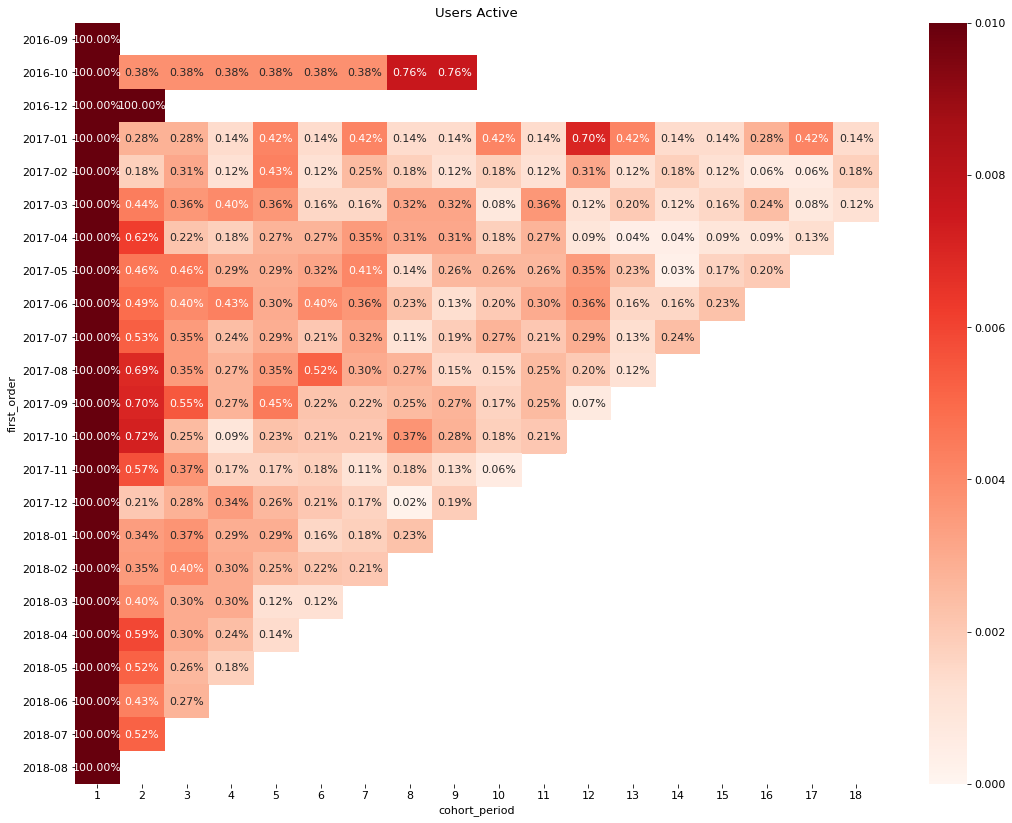

In [151]:
#построим график и переведем в проценты
plt.rcParams['font.size'] = '11'
plt.figure(figsize=(18,14))
plt.title('Users Active')
ax = sns.heatmap(data=retention, annot=True, vmin=0,vmax=0.01 ,cmap='Reds',fmt='.2%')
ax.set_yticklabels(retention.index)
fig=ax.get_figure()

plt.show()

#### Ну и выводы: график возвратов пользователе выглядит очень плачевно. Что в прочем не удивительно, учитывая, что примерно 94 процента пользователей сделали только 1 покупку.

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Описание подхода можно найти тут. (23 балла)

In [152]:
olist_orders_rfm = olist_orders.merge(olist_customers, on='customer_id', how='left')
orders_uniq_rfm = olist_orders_rfm.merge(olist_order_items, how='left', on='order_id')
orders_uniq_rfm.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [153]:
#проверяем результат merge
orders_uniq_rfm[orders_uniq_rfm.order_id == '8272b63d03f5f79c56e9e4120aec44ef'].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
101222,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,1.0,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101223,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,2.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101224,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,3.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101225,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,4.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
101226,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,5.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [154]:
#фильтруем только выполненные заказы
orders_uniq_rfm_filtred = orders_uniq_rfm[orders_uniq_rfm.order_status == 'delivered']

In [155]:
#убираем лишние колонки
orders_uniq_rfm_filtred_r = orders_uniq_rfm_filtred[['customer_unique_id','order_id','order_purchase_timestamp','price']]
orders_uniq_rfm_filtred_r.head()

,customer_unique_id,order_id,order_purchase_timestamp,price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90


In [156]:
orders_uniq_rfm_filtred_r.order_purchase_timestamp.max()

Timestamp('2018-08-29 15:00:37')

In [157]:
datetime.now() - orders_uniq_rfm_filtred.order_purchase_timestamp.max()

Timedelta('1509 days 04:31:53.364915')

In [158]:
#сортируем по колонке order_purchase_timestamp
orders_uniq_rfm_filtred_r = orders_uniq_rfm_filtred_r.sort_values(by='order_purchase_timestamp')

In [159]:
#берем только последнюю покупку
orders_uniq_rfm_filtred_r = orders_uniq_rfm_filtred_r.groupby(['customer_unique_id'],as_index=False)\
                                 .agg({'order_purchase_timestamp':'first'})
orders_uniq_rfm_filtred_r.head()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [160]:
#сравниваем количество пользователе в полученной таблице с униками из основной для проверки того, что мы ни чего не потеряли.
orders_uniq_rfm_filtred_r.agg({'customer_unique_id':'count'}) == orders_uniq_rfm[orders_uniq_rfm.order_status == 'delivered'].agg({'customer_unique_id':'nunique'})

customer_unique_id    True
dtype: bool

### Настал момент определить, от какого момента считать разницу во времени. В задании предлагается считать от текущего времент. Но  цифры получатся довольно большими и с ними будет не очень удобно работать. Т.к. решение за мной, то возьму за отсчет максимальную дату в таблице + 1 день. Предположим, что анализ проводился на след. день после выгрузки данных.

In [161]:
time = orders_uniq_rfm_filtred_r.order_purchase_timestamp.max() + pd.Timedelta("1 day")
time

Timestamp('2018-08-30 15:00:37')

In [162]:
#создаем колонку с timedelta.
orders_uniq_rfm_filtred_r['time_delta'] = time - orders_uniq_rfm_filtred_r.order_purchase_timestamp

In [163]:
orders_uniq_rfm_filtred_r.time_delta.describe()

count                          93358
mean     241 days 02:42:04.619496992
std      153 days 02:25:49.622158098
min                  1 days 00:00:00
25%         117 days 00:46:58.750000
50%                222 days 08:12:30
75%         350 days 23:19:14.500000
max                714 days 02:43:59
Name: time_delta, dtype: object

#### Осталось определить, на какие диапазоны разделить пользователей. Нас в первую очередь интересуют пользователи, которые делали заказы не давно. Возьмем за последнюю границу 25 квантиль 117 дней(все что больше 117 дней будет в 3 группе).
#### За вторую границу возьмем q=0.125 58 дней.
#### За первую границу возьмем q=0.0625 28 дней

In [164]:
#создадим колонку r_score и поделим пользователей на группы
bins = [pd.Timedelta("0 day"),pd.Timedelta("28 day"),pd.Timedelta("117 day"),pd.Timedelta("1000 day")]

orders_uniq_rfm_filtred_r['r_score'] = pd.cut(orders_uniq_rfm_filtred_r['time_delta'],bins = bins , labels=[3,2,1])

In [165]:
#перенесем нужные нам колонки в отдельный датафрейм
r_score = orders_uniq_rfm_filtred_r[['customer_unique_id','r_score']]

In [166]:
r_score

,customer_unique_id,r_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1
93354,fffea47cd6d3cc0a88bd621562a9d061,1
93355,ffff371b4d645b6ecea244b27531430a,1
93356,ffff5962728ec6157033ef9805bacc48,1


In [167]:
#посчитаем количество заказов на каждого клиента
orders_count = orders_uniq_rfm_filtred.groupby('customer_unique_id',as_index=False) \
                                      .agg({'order_id':'count'})\
                                      .rename(columns=({'order_id':'order_id_count'}))
orders_count.head()

,customer_unique_id,order_id_count
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [168]:
orders_count.order_id_count.describe()

count    93358.000000
mean         1.180370
std          0.620857
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: order_id_count, dtype: float64

Ну сразу поделить на квантили тут явно не получится. Пользователей, которые сделали всего один заказ, следует определить в 3 группу. Все что больше одного заказа посмотрим поподробнее.

In [169]:
orders_count[orders_count.order_id_count > 1].describe()

,order_id_count
count,11610.000000
mean,2.450388
std,1.121445
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,24.000000


#### Основное количество покупателей, которые сделали более одного заказа, сделали не более 2-х. Второй границей сделаем 2 покупки.  Ну и будем считать тех кто сделал более 3-х покупок самыми ценными. 
#### Принимаю решение о таких градациях, только потому, что покупателей которые сделали более 1 покупки очень мало и их надо как то разделить.

In [170]:
#делим на группы
orders_count['f_score'] = pd.cut(orders_count['order_id_count'],bins = [0,1.9,3,25] , labels=[1,2,3])

In [171]:
#оставляем только нужные ячейка
f_score = orders_count[['customer_unique_id','f_score']]

In [172]:
#считаем общую выручку по каждому клиенту.
orders_m = orders_uniq_rfm_filtred.groupby('customer_unique_id', as_index=False)\
                       .agg({'price':'sum'})\
                       .rename(columns=({'price':'price_sum'}))

In [173]:
orders_m.price_sum.describe()

count    93358.000000
mean       141.621480
std        215.694014
min          0.850000
25%         47.650000
50%         89.730000
75%        154.737500
max      13440.000000
Name: price_sum, dtype: float64

С потраченными средствами наверное все проще. Разьбью по квантилям на равные части.

In [174]:
#делим на группы по квантилям
orders_m['m_score'] = pd.qcut(orders_m['price_sum'],q = [0,0.33,0.66,1] , labels=[1,2,3])

In [175]:
#оставляем нужные ячейки
m_score = orders_m[['customer_unique_id','m_score']]

In [176]:
m_score.head()

,customer_unique_id,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,2
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,3


In [177]:
#соединяем все полученные дата фреймы в 1
rfm_orders = r_score
rfm_orders = rfm_orders.merge(f_score, on='customer_unique_id', how='left')
rfm_orders = rfm_orders.merge(m_score, on='customer_unique_id', how='left')

In [178]:
#проверяем на пустые значения. общее количество совпадает. мы ни чего не потеряли.
rfm_orders.isnull().value_counts()

customer_unique_id  r_score  f_score  m_score
False               False    False    False      93358
dtype: int64

In [179]:
rfm_orders.head()

,customer_unique_id,r_score,f_score,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,1,1
2,0000f46a3911fa3c0805444483337064,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,1,1,3


In [180]:
#формируем столбец с итоговым RFM показателем
rfm_orders['RFM'] = rfm_orders.r_score.astype(str) \
    +rfm_orders.f_score.astype(str) \
    +rfm_orders.m_score.astype(str)
rfm_orders.head()

,customer_unique_id,r_score,f_score,m_score,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,2,1,3,213
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,1,1,211
2,0000f46a3911fa3c0805444483337064,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,1,1,3,113


In [181]:
#считаем количество каждого сегмента и добавим расчет доли от бощего количества в процентах
RFM_total = rfm_orders.RFM.value_counts().to_frame()
RFM_total['share'] =  (RFM_total.RFM / RFM_total.sum()['RFM']) * 100

In [182]:
RFM_total

,RFM,share
111,21914,23.473082
112,20272,21.714261
113,18723,20.055057
211,5513,5.905225
212,5267,5.641723
213,4870,5.216479
123,4425,4.739819
122,2680,2.870670
311,1919,2.055528
312,1758,1.883074


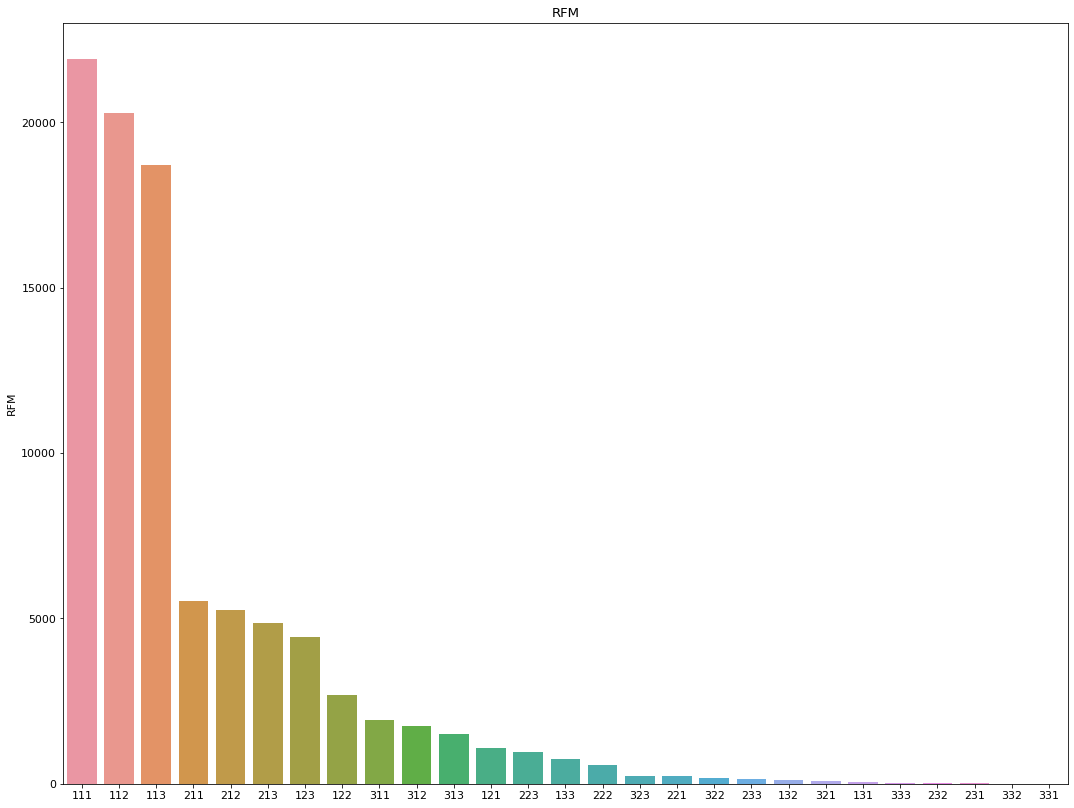

In [183]:
#построим barplot для большей наглядности
plt.figure(figsize=(18,14))
plt.title('RFM')
sns.barplot(x=RFM_total.index, y= RFM_total.RFM)

### Итого по RFM. Количество лояльных клиентов минимально их явно надо беречь.

### Я ожидал большее количество клиентов с 111. Явно есть небольшая доля клиентов, которые покупали недавно и имеют не плохие показатели, по остальным критериям. Есть с чем работать и пробовать не потерять лояльных клиентов. И подталкивать к покупке тех кто покупал давно.

## Общий итог. 

## Конечно хотелось бы поработать с более позитивными данными, ну да что есть.

## Проект лично для меня оказался очень интересным. Было бы неплохо, что бы методы кагортного и RFM анализа рассматривались в курсе. Но навык самостоятельно находить материалы то же полезен. 

## Не судите строго, это мой первый опыт подобного проекта. Надеюсь на развернутые комментарии.